









































































































































































































































































































































































































































































































































































































# Linear Regression Model
This is a simple linear regression model in which i will try to find out the relationship between two indices DOW JONES and NIFTY 50 so that it can help to trade nifty by taking reference from dow jones.



__The question i'm trying to answer is does the explanatory variable(Dow jones) do a good job at predicting the dependent variable(Nifty 50)__

# Import libraries

In [211]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy import stats
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import MinMaxScaler


# Load Data and clean


In [212]:
#Load data through yahoo finance lib
df = yf.download(['^Dji','^NSEI'], start = '2012-01-01', end='2022-01-01')
#sort data to get only close price as input
df= df['Close']
#check for null values
df.isna().sum()
#drop null values
df = df.dropna()
df.head(5)


[*********************100%***********************]  2 of 2 completed


,^DJI,^NSEI
Date,,
2012-01-03,12397.379883,4765.299805
2012-01-04,12418.419922,4749.649902
2012-01-05,12415.700195,4749.950195
2012-01-06,12359.919922,4754.100098
2012-01-09,12392.690430,4742.799805


In [213]:
#change the columns name
new_columns = {'^DJI': 'Dow Jones', '^NSEI': 'Nifty50'}
df = df.rename(columns = new_columns)
df.head()

,Dow Jones,Nifty50
Date,,
2012-01-03,12397.379883,4765.299805
2012-01-04,12418.419922,4749.649902
2012-01-05,12415.700195,4749.950195
2012-01-06,12359.919922,4754.100098
2012-01-09,12392.690430,4742.799805


In [214]:
# check for data types
df.dtypes

Dow Jones    float64
Nifty50      float64
dtype: object

# Explore the data

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

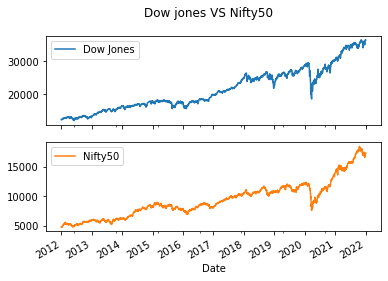

In [215]:
# visualize the data
df.plot(title = 'Dow jones VS Nifty50', subplots= True)


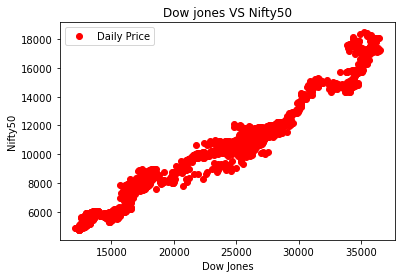

In [216]:
#plotting data
x = df['Dow Jones']
y = df['Nifty50']
# create scatter plot.
plt.plot(x, y, 'o', color = 'Red', label = 'Daily Price')
plt.title('Dow jones VS Nifty50')
plt.xlabel('Dow Jones')
plt.ylabel('Nifty50')
plt.legend()
plt.show()

In [217]:
# Measure the Correlation
df.corr()

,Dow Jones,Nifty50
Dow Jones,1.000000,0.975987
Nifty50,0.975987,1.000000


In [218]:
# stats summary
df.describe()

,Dow Jones,Nifty50
count,2386.000000,2386.000000
mean,21471.641633,9407.481287
std,6355.859120,3070.636569
min,12101.459961,4742.799805
25%,16461.675293,7417.500122
50%,19886.555664,8771.900391
75%,26003.352539,11075.287842
max,36488.628906,18477.050781


array([[<AxesSubplot:title={'center':'Dow Jones'}>,
        <AxesSubplot:title={'center':'Nifty50'}>]], dtype=object)

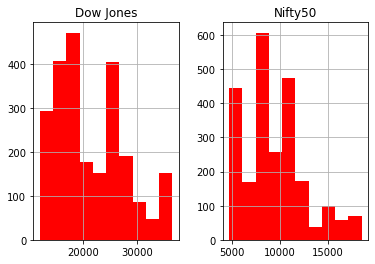

In [219]:
df.hist(color = 'Red')

In [220]:
#calculate kurtosis
dowjones_kurtosis = kurtosis(df['Dow Jones'])
nifty_kurtosis = kurtosis(df['Nifty50'])
#calculate skewness
dowjones_skew = skew(df['Dow Jones'])
nifty_skew = skew(df['Nifty50'])

display("Dowjones kurtosis: {:2}".format(dowjones_kurtosis))
display("Nifty kurtosis: {:2}".format(nifty_kurtosis))

display("Dowjones skew: {:2}".format(dowjones_skew))
display("Nifty skew: {:2}".format(nifty_skew))


'Dowjones kurtosis: -0.640211451997243'

'Nifty kurtosis: 0.3120750782896171'

'Dowjones skew: 0.5563976355396298'

'Nifty skew: 0.7803562725140293'

# Transform skewed data into normal distribution
As we can see that data of both variable is highly negatively skewed so we need to transform it first

C:\Users\pande\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Dow Jones'>

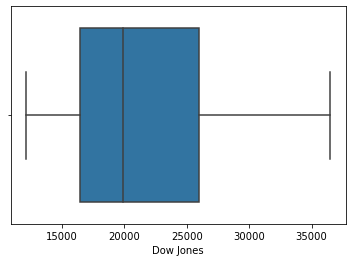

In [221]:
sns.boxplot(df['Dow Jones'])


C:\Users\pande\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Nifty50'>

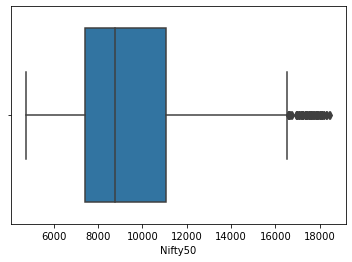

In [222]:
sns.boxplot(df['Nifty50'])

In [223]:
#transform 'Dow Jones' data with boxcox method and insert it into the same dataframe
from scipy.stats import boxcox
df.insert(len(df.columns), 'Dowjones_trans', 
                  boxcox(df.iloc[:, 0])[0])


In [224]:
#drop the previous column
df = df.drop(columns=['Dow Jones'])

In [225]:
#transform 'Nifty50' data with boxcox method and insert it into the same dataframe
df.insert(len(df.columns), 'Nifty50trans', 
                  boxcox(df.iloc[:, 0])[0])

array([[<AxesSubplot:title={'center':'Nifty50'}>,
        <AxesSubplot:title={'center':'Dowjones_trans'}>],
       [<AxesSubplot:title={'center':'Nifty50trans'}>, <AxesSubplot:>]],
      dtype=object)

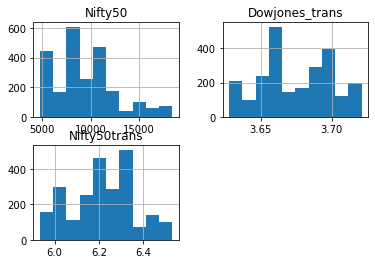

In [226]:
#show all histograms
df.hist()

In [227]:
df =df.drop(columns=['Nifty50'])

array([[<AxesSubplot:title={'center':'Dowjones_trans'}>,
        <AxesSubplot:title={'center':'Nifty50trans'}>]], dtype=object)

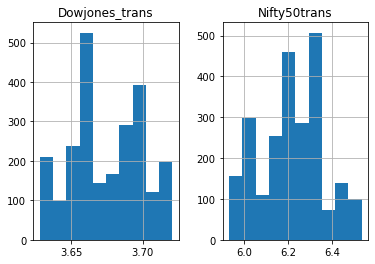

In [228]:
df.hist()

#   Defining Model 

In [229]:
#define out input variable(x) & output variable.
Y = df.drop('Dowjones_trans', axis=1)
X = df[['Dowjones_trans']]
# Split x and y into x
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size =0.20, random_state=1)

In [230]:
regression_model = LinearRegression()
#pass through the x_train & y_train data set.
regression_model.fit(x_train, y_train)

LinearRegression()

In [231]:
intercept = regression_model.intercept_[0]
coefficient = regression_model.coef_[0][0]

print("Coefficient = {:.2}".format(coefficient))
print("Intercept = {:.2}".format(intercept))

Coefficient = 5.6
Intercept = -1.5e+01


In [232]:
#predicion
prediction = regression_model.predict([[34000]])
predicted_value = prediction[0][0]
predicted_value

191745.7563028176

# Evaluating Model

In [233]:
X2 = sm.add_constant(x)
model = sm.OLS(Y,X2)
est = model.fit()

In [234]:
est.conf_int()

,0,1
const,5.753176,5.764037
Dow Jones,0.000021,0.000022


In [195]:
est.pvalues

const        0.0
Dow Jones    0.0
dtype: float64

In [196]:
model_mse = mean_squared_error(y_test, y_predict)
model_mae = mean_absolute_error(y_test, y_predict)
model_rmse = math.sqrt(model_mse)
print(f'MSE {model_mse}')
print(f'MAE {model_mae}')
print(f'RMSE {model_rmse}')

MSE 0.0009024417274424688
MAE 0.024400572853632414
RMSE 0.030040667892749468


In [197]:
model_r2 = r2_score(y_test, y_predict)
print(f' R2 {model_r2}')

 R2 0.9533581695882943


In [198]:
#Summary
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:           Nifty50trans   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                 3.011e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        11:47:42   Log-Likelihood:                 4393.7
No. Observations:                2386   AIC:                            -8783.
Df Residuals:                    2384   BIC:                            -8772.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7586      0.003   2079.368      0.0

<function matplotlib.pyplot.show(close=None, block=None)>

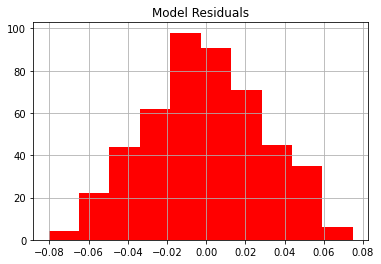

In [199]:
(y_test - y_predict).hist(grid = True, color='Red')
plt.title('Model Residuals')
plt.show

In [200]:
residuals = (y_test - y_predict)
skew(residuals)

array([0.0001189])

# Conclusion 
It can be seen from the above analysis that both indices are highly correlated with each others but both were positively skewed. I tried to transform it through various ways i.e taking log into consideration later used boxcox method i can say as per this model x variable is pretty good in defining the y variable as R2 is high but a single variable isnt enough to define nifty50 movement may be a multiple regression method can work better than this one.